
# **[군장병 AI 기본1] Image Processing**

* ### Hak Gu Kim, Ph.D.
  * ### Assistant Professor
  * ### Graduate School of Advanced Imaging Science, Multimedia & Film (GSAIM)
  * ### Chung-Ang University
  * ### Webpage: www.irislab.cau.ac.kr


# **Programming Practice III: Panorama Stitching**

### 1. Understande SIFT descriptor
### 2. Implement RANSAC algorithm with SIFT descriptor features
### 3. Perform your own panorama images using two view images

## **[Step 0]** Environmental Setting

In [27]:
# Import the required libraries for image processing

import sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = [15, 15]

# Define the directory
dir = os.getcwd()

ModuleNotFoundError: No module named 'google'

In [19]:
# Define the functions for the load and save the input image

def loadImg(in_fname):
  img = cv2.imread(dir + in_fname)

  if img is None:
    print('Image load failed!')
    sys.exit()

  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title("Input RGB Image")
  plt.show()

  return img

## Save image file
def saveImg(out_img, out_fname):
  cv2.imwrite(dir + out_fname, out_img)

In [20]:
# Define the functions for panorama image generation

##############################################
#          Transformation Matrix, H          #
##############################################
def homography(pairs):
    rows = []
    for i in range(pairs.shape[0]):
        p1 = np.append(pairs[i][0:2], 1)
        p2 = np.append(pairs[i][2:4], 1)
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        rows.append(row1)
        rows.append(row2)

    rows = np.array(rows)
    U, s, V = np.linalg.svd(rows)
    H = V[-1].reshape(3, 3)
    H = H/H[2, 2] # standardize to let w*H[2,2] = 1
    return H


##############################################
#         Panoramic Image Generation         #
##############################################
def stitchImg(left, right, H):
    print("stiching image ...")

    # Convert to double and normalize. Avoid noise.
    left = cv2.normalize(left.astype('float'), None,
                            0.0, 1.0, cv2.NORM_MINMAX)
    # Convert to double and normalize.
    right = cv2.normalize(right.astype('float'), None,
                            0.0, 1.0, cv2.NORM_MINMAX)

    # left image
    height_l, width_l, channel_l = left.shape
    corners = [[0, 0, 1], [width_l, 0, 1], [width_l, height_l, 1], [0, height_l, 1]]
    corners_new = [np.dot(H, corner) for corner in corners]
    corners_new = np.array(corners_new).T
    x_news = corners_new[0] / corners_new[2]
    y_news = corners_new[1] / corners_new[2]
    y_min = min(y_news)
    x_min = min(x_news)

    translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H = np.dot(translation_mat, H)

    # Get height, width
    height_new = int(round(abs(y_min) + height_l))
    width_new = int(round(abs(x_min) + width_l))
    size = (width_new, height_new)

    # right image
    warped_l = cv2.warpPerspective(src=left, M=H, dsize=size)

    height_r, width_r, channel_r = right.shape

    height_new = int(round(abs(y_min) + height_r))
    width_new = int(round(abs(x_min) + width_r))
    size = (width_new, height_new)


    warped_r = cv2.warpPerspective(src=right, M=translation_mat, dsize=size)

    black = np.zeros(3)  # Black pixel.

    # Stitching procedure, store results in warped_l.
    for i in tqdm(range(warped_r.shape[0])):
        for j in range(warped_r.shape[1]):
            pixel_l = warped_l[i, j, :]
            pixel_r = warped_r[i, j, :]

            if not np.array_equal(pixel_l, black) and np.array_equal(pixel_r, black):
                warped_l[i, j, :] = pixel_l
            elif np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                warped_l[i, j, :] = pixel_r
            elif not np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                warped_l[i, j, :] = (pixel_l + pixel_r) / 2
            else:
                pass

    stitch_image = warped_l[:warped_r.shape[0], :warped_r.shape[1], :]
    return stitch_image


def plot_sift(gray_img, rgb_img, keypnt):
    tmp_img = rgb_img.copy()
    sift_on_img = cv2.drawKeypoints(gray_img, keypnt, tmp_img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return sift_on_img


def plot_matches(matches, total_img):
    match_img = total_img.copy()
    offset = total_img.shape[1]/2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(match_img).astype('uint8')) #　RGB is integer type

    ax.plot(matches[:, 0], matches[:, 1], 'xr')
    ax.plot(matches[:, 2] + offset, matches[:, 3], 'xr')

    ax.plot([matches[:, 0], matches[:, 2] + offset], [matches[:, 1], matches[:, 3]],
            'r', linewidth=0.5)

    plt.show()

## **[Practice III-1]** Understande SIFT descriptor feature and matching
* Following codes are SIFT Feature Extraction and Matching
* There is nothing for you to do in this field

In [24]:
##############################################
#             Feature Extraction             #
##############################################
def SIFT(img):
    siftDetector= cv2.SIFT_create() # limit 1000 points
    # siftDetector= cv2.SIFT_create()  # depends on OpenCV version

    kp, des = siftDetector.detectAndCompute(img, None)
    return kp, des  # keypoints & descriptors


##############################################
#               Feature Matching             #
##############################################
def siftMatch(kp1, des1, img1, kp2, des2, img2, threshold):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < threshold*n.distance:
            good.append([m])

    matches = []
    for pair in good:
        matches.append(list(kp1[pair[0].queryIdx].pt + kp2[pair[0].trainIdx].pt))

    matches = np.array(matches)
    return matches



## ## **[Practice III-2]** Implement RANSAC algorithm with SIFT descriptor features
* This is main part in this practice
* Carefully read and understand the following RANSAC code,
* Then please **complete the incomplete code:** `varable_name = [ ]`

In [25]:
##############################################
#                   RANSAC                   #
##############################################
def ransac(matches, k_samples, threshold, iters):
    num_best_inliers = 0

    for i in range(iters):
        rand_pnt = randomPoint(matches, k_samples)
        H = homography(rand_pnt)

        # Avoid dividing by zero
        if np.linalg.matrix_rank(H) < 3:
            continue

        errs = getError(matches, H)
        idx = np.where(errs < threshold)[0]
        inliers = matches[idx]

        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            ############################################
            ##       COMPLETE THE FOLLOWING CODE      ##
            ############################################
            # Find the best inliers and transformation matrix, H
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H.copy()

    print("inliers/matches: {}/{}".format(num_best_inliers, len(matches)))
    return best_inliers, best_H

def randomPoint(matches, k_samples):
  ############################################
  ##       COMPLETE THE FOLLOWING CODE      ##
  ############################################
  # k_samples: the number of random points
  # Randomly sample the K well-matched keypoints (i.e., matches)
  # Fianlly return the randomly sampled well-matched keypoints (i.e., matches), rand_pnt
  idx = random.sample(range(len(matches)), k_samples)
  rand_pnt = [matches[i] for i in idx ]

  return np.array(rand_pnt)

def getError(rand_pnt, H):
    num_points = len(rand_pnt)
    all_p1 = np.concatenate((rand_pnt[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = rand_pnt[:, 2:4]

    est_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        ############################################
        ##       COMPLETE THE FOLLOWING CODE      ##
        ############################################
        # Calculate the estimated p2
        # The estimated p2 = H*p1
        temp_est_p2 = np.dot(H, all_p1[i])

        est_p2[i] = (temp_est_p2/temp_est_p2[2])[0:2] # set index 2 to 1 and slice the index 0, 1

    ############################################
    ##       COMPLETE THE FOLLOWING CODE      ##
    ############################################
    # Compute error
    errors = np.linalg.norm(all_p2 - est_p2 , axis=1) ** 2

    return errors

## **[Practice III-3]** Perform your own panorama images using two view images

* Try to change various variables such as the number of samples, threshold, the number of iterations in RANSAC function
* Try to get your own panorama image with the pictures you took

C:\Users\user\Desktop\military_ai_3\img_left.jpg
4001
(4001, 128)


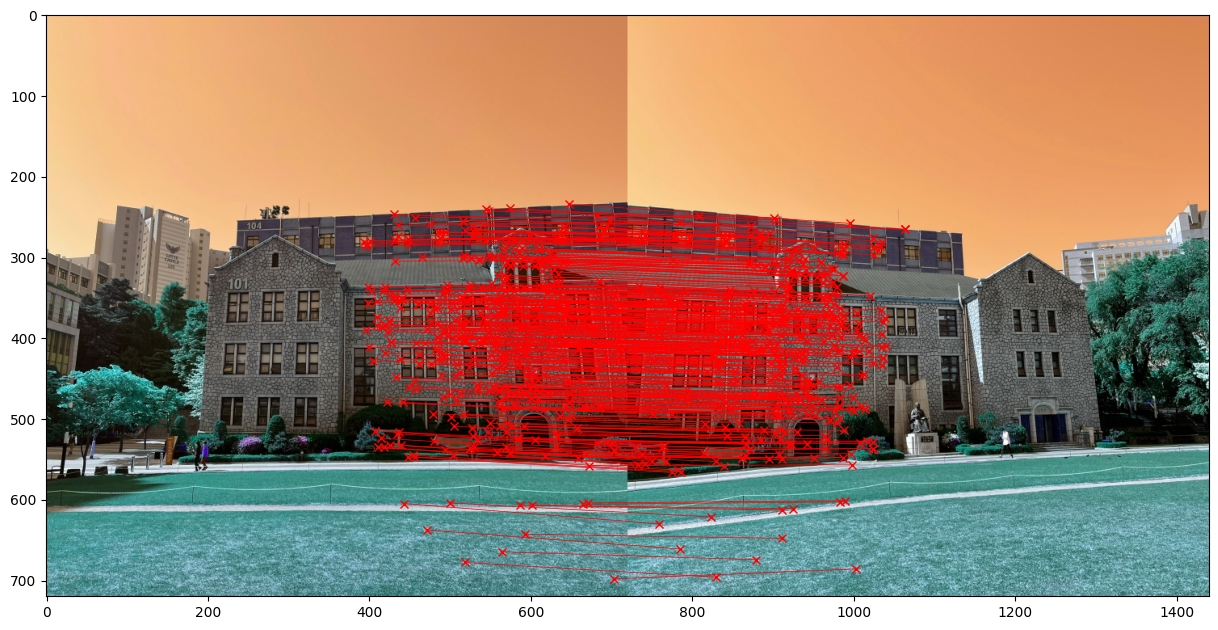

(442, 4)
inliers/matches: 181/442


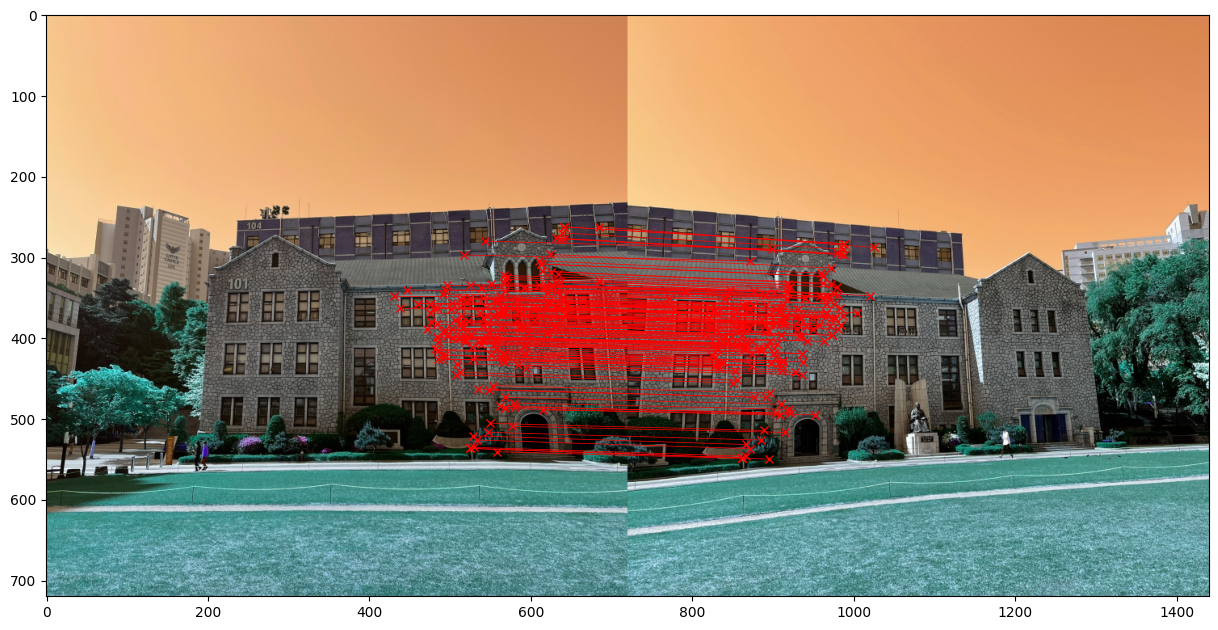

stiching image ...


  0%|          | 0/1026 [00:00<?, ?it/s]

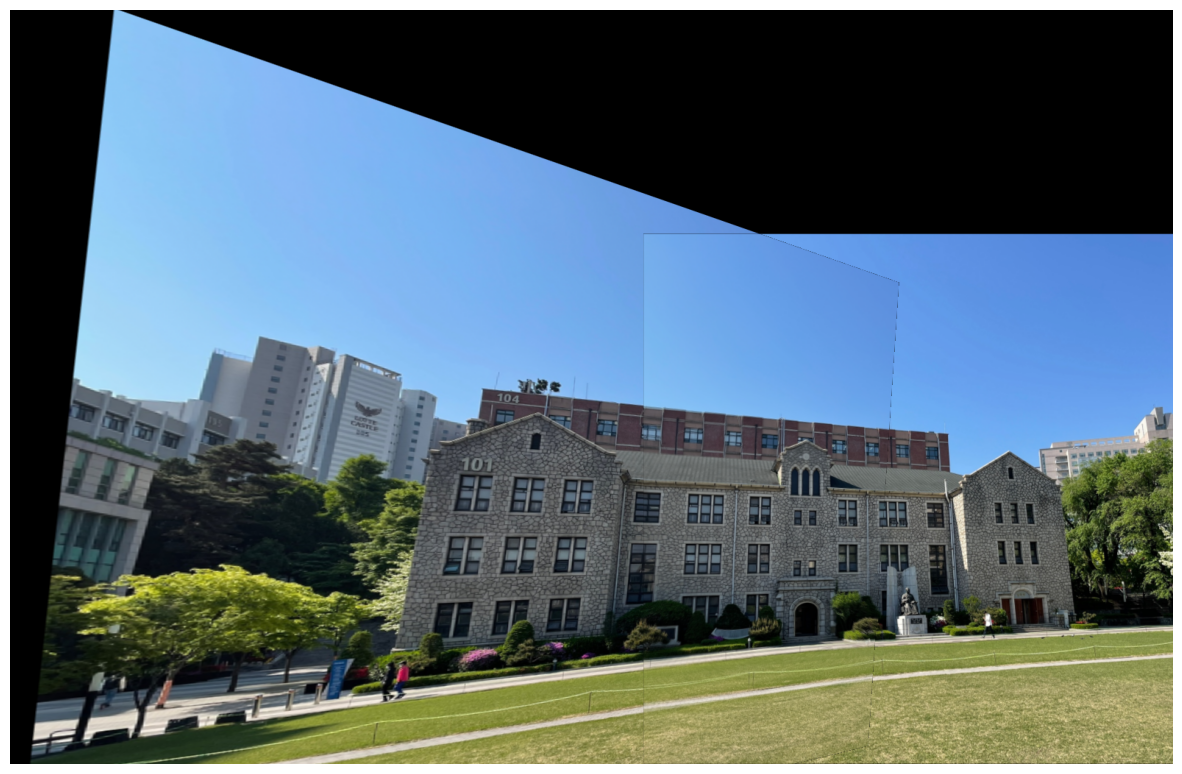

In [30]:
##############################################
#                Main Function               #
##############################################

if __name__ == "__main__":

    fname_left = '\img_left.jpg'
    fname_right = '\img_right.jpg'
    print(dir + fname_left)
    img_left  = cv2.resize(cv2.imread(dir + fname_left), dsize=(720, 720))
    img_right = cv2.resize(cv2.imread(dir + fname_right), dsize=(720, 720))

    gray_left = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

    kp_left, des_left = SIFT(gray_left)
    kp_right, des_right = SIFT(gray_right)

    print(len(kp_left))   # The number of keypoints on the left image
    print(des_left.shape) # The 128-dimensional descriptor for each keypoint

    kp_left_img = plot_sift(gray_left, img_left, kp_left)
    kp_right_img = plot_sift(gray_right, img_right, kp_right)
    #total_kp = np.concatenate((kp_left_img, kp_right_img), axis=1)
    #plt.imshow(total_kp)

    matches = siftMatch(kp_left, des_left, img_left, kp_right, des_right, img_right, 0.5)   # The coordinates of the matched correspondences p1=[x, y] and p2=[x', y']
    temp_img = np.concatenate((img_left, img_right), axis=1)
    plot_matches(matches, temp_img) # Good mathces

    print(matches.shape)  # The number of well-matched keypoints (i.e., correspondences)


    inliers, H = ransac(matches, 400, 0.5, 1000)
    plot_matches(inliers, temp_img) # show inliers matches

    panoramic_img = stitchImg(img_left, img_right, H)*255

    img_rgb = cv2.cvtColor(panoramic_img.astype('uint8'), cv2.COLOR_BGR2RGB)
    # 이미지 표시
    plt.imshow(img_rgb)
    plt.axis('off')  # 축 숨기기
    plt.show()